In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms


# Project: Olist Supply Chain Optimization & Seller Retention Strategy

### Business Context: The "Marketplace Integrator" Model
**Olist** operates as a pivotal "Digital Bridge" for Brazilian Small and Medium Enterprises (SMEs). Unlike traditional retailers, Olist does not own inventory. Instead, it connects small merchants to massive marketplaces like Mercado Livre, Amazon, and Americanas.

*   **The Value Proposition:** Sellers upload products once to Olist, and Olist manages listings, logistics coordination, and reputation management across multiple platforms.
*   **The Challenge:** Connecting thousands of scattered sellers to millions of buyers across Brazil's vast geography creates significant logistical complexity.

---

### Problem Statement: The "Scale Paradox"
While Olist democratizes e-commerce access, the business faces three critical operational risks that this analysis aims to investigate:

1.  **Spatial Imbalance:** We hypothesize that the concentration of sellers in major hubs (like São Paulo) does not align with the distributed demand across the country, potentially driving up shipping costs.
2.  **Logistics Visibility:** Operational data—specifically regarding carrier handovers—is often incomplete. Without restoring these timelines, it is impossible to accurately judge seller performance.
3.  **Seller Churn Risk:** Operational delays in the "First Mile" (the time taken for a seller to hand a package to a carrier) are suspected to be a leading indicator of seller attrition.

---

### Project Objectives & Analytical Roadmap
This notebook serves as a **Strategic Audit** of the Olist ecosystem. We will execute the following phases to diagnose the health of the supply chain:

**Phase 1: Data Engineering & Timeline Restoration**
*   **Objective:** To address the "Missing Data" problem.
*   **Methodology:** We will implement advanced imputation techniques (benchmarking individual seller history) to recover lost logistics timestamps, ensuring we don't discard valuable sales data.

**Phase 2: Operational Diagnosis (The "First Mile" Audit)**
*   **Objective:** To measure **Processing Latency**.
*   **Key Question:** How long does the average seller take to process an order? Are there specific product categories that act as bottlenecks in the supply chain?

**Phase 3: Strategic Expansion (Market Gap Analysis)**
*   **Objective:** To locate "Supply Deserts."
*   **Key Question:** Can we identify cities where buyer demand is high, but local seller supply is non-existent? These regions will represent prime targets for future merchant acquisition.

---

### Stakeholder
This analysis is designed to answer critical business questions for the following key teams:

| Stakeholder | Key Business Question to Answer |
| :--- | :--- |
| **Head of Partnerships** | *"Which specific cities should we prioritize for recruiting new local sellers to reduce freight costs?"* |
| **Operations Director** | *"Is the delay in delivery caused by the logistics carriers or by the sellers themselves?"* |
| **Account Managers** | *"What are the early warning signs (in terms of processing speed) that a seller is about to leave the platform?"* |




### **Load Dataset**

In [149]:
base_dir = "/Users/dyahalmira/Downloads/kaggle/"

In [150]:
sellers_df = pd.read_csv(base_dir + "seller_df.csv")
products = pd.read_csv("/Users/dyahalmira/Downloads/kaggle/brazilian-ecommerce/olist_products_dataset.csv")
translation = pd.read_csv("/Users/dyahalmira/Downloads/kaggle/brazilian-ecommerce/product_category_name_translation.csv")


In [151]:
sellers_df.head(5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,sports_leisure,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01 00:00:00,campinas,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,sports_leisure,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30 00:00:00,campinas,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,sports_leisure,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20 00:00:00,campinas,SP
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,luggage_accessories,9facbfd2dd51a45404d58154b12ed2dd,delivered,2017-11-10 16:54:13,2017-11-14 04:31:07,2017-11-14 20:06:59,2017-11-21 23:26:35,2017-12-04 00:00:00,mogi-guacu,SP
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,stationery,4e2c1f15de98416a90c2ee06b55ccc9b,delivered,2017-09-28 19:31:57,2017-09-30 02:14:42,2017-10-02 19:33:19,2017-10-06 17:03:59,2017-11-03 00:00:00,mogi-guacu,SP


In [152]:
sellers_df.isna().sum()

seller_id                           0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
order_id                            0
order_item_id                       0
product_id                          0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name_english    1627
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
geolocation_city                  253
geolocation_state                 253
dtype: int64

### **A. Temporal Data Normalization and Type Conversion**

For any logistics or churn analysis, time is the primary dimension. However, raw datasets often load date information as "object" (string) types. To perform arithmetic operations—such as calculating shipping delays or seller tenure—we must convert these attributes into standardized **Datetime** objects.
* **Type Casting:** Transform all date-related columns from strings into high-precision Pandas Datetime objects.
* **Consistency:** Ensure that all temporal columns across the `sellers_df` are synchronized for time-series analysis.
* **Enable Analytics:** Unlock the ability to use specialized Datetime properties (e.g., `.dt.days`, `.dt.month`) for granular performance reporting.

In [153]:
datetime_columns = [
    'shipping_limit_date', 
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]

for col in datetime_columns:
    sellers_df[col] = pd.to_datetime(sellers_df[col])

# Verify the transformation
print("Datetime conversion successful. Updated schema:")
print(sellers_df[datetime_columns].dtypes)

Datetime conversion successful. Updated schema:
shipping_limit_date              datetime64[ns]
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


In [154]:
sellers_df['seller_state'] = sellers_df['seller_state'].astype('category')
sellers_df['order_status'] = sellers_df['order_status'].astype('category')

In [155]:
sellers_df['seller_zip_code_prefix'] = sellers_df['seller_zip_code_prefix'].astype(str)

In [156]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   seller_id                      112650 non-null  object        
 1   seller_zip_code_prefix         112650 non-null  object        
 2   seller_city                    112650 non-null  object        
 3   seller_state                   112650 non-null  category      
 4   order_id                       112650 non-null  object        
 5   order_item_id                  112650 non-null  int64         
 6   product_id                     112650 non-null  object        
 7   shipping_limit_date            112650 non-null  datetime64[ns]
 8   price                          112650 non-null  float64       
 9   freight_value                  112650 non-null  float64       
 10  product_category_name_english  111023 non-null  object        
 11  

In [157]:
sellers_df.isna().sum()

seller_id                           0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
order_id                            0
order_item_id                       0
product_id                          0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name_english    1627
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
geolocation_city                  253
geolocation_state                 253
dtype: int64

In [158]:
df_products = pd.merge(products, translation, on='product_category_name', how='left')

### **Product Category Translation and Localization**

The raw Olist dataset contains product category names in Portuguese. To ensure the final report is accessible to an international audience and to facilitate clearer analysis, we must translate these categories into English. 
* **Data Enrichment:** Merge the product dataset with a translation reference table.
* **Gap Analysis:** Identify categories that exist in the database but are missing from the standard translation file.
* **Manual Imputation:** Apply a custom mapping for rare or newly added categories that were not captured in the initial translation bridge.

In [159]:
# 1. Merge products with the translation table (Left Join)
df_products = pd.merge(products, translation, on='product_category_name', how='left')

print("Count of categories missing English translations:")
print(df_products['product_category_name_english'].isnull().sum())

# 2. Identify records with a Portuguese name but no English counterpart
missing_translation = df_products[
    df_products['product_category_name_english'].isnull() & 
    df_products['product_category_name'].notnull()
]
print(f"There are {len(missing_translation)} records with Portuguese names lacking English translations.")

# 3. Extract unique categories that require manual mapping
missing_list = df_products[
    df_products['product_category_name_english'].isnull() & 
    df_products['product_category_name'].notnull()
]['product_category_name'].unique()

print("Categories requiring manual translation:")
print(missing_list)

# 4. Define custom mapping for specific missing categories
mapping_category = {
    'pc_gamer': 'pc_gamer',
    'portateis_cozinha_e_preparadores_de_alimentos': 'kitchen_portables'
}

# 5. Fill missing values based on the custom mapping
df_products['product_category_name_english'] = df_products['product_category_name_english'].fillna(
    df_products['product_category_name'].map(mapping_category)
)

Count of categories missing English translations:
623
There are 13 records with Portuguese names lacking English translations.
Categories requiring manual translation:
['pc_gamer' 'portateis_cozinha_e_preparadores_de_alimentos']


---
To ensure every transaction is linked to a readable product category, we perform a final synchronization between our sales data and the refined product reference table. This step replaces technical Portuguese identifiers with the English translations we prepared earlier.

* **Data Refresh:** Drop old category columns to prevent duplicate information during the merge.
* **Metadata Injection:** Map the cleaned English category names from `product_ref` into the primary `sellers_df`.
* **Zero-Null Enforcement:** Apply a fallback label ('uncategorized') for items without a defined category, ensuring the dataset remains structurally sound for aggregation.
* **Integrity Audit:** Verify if any critical order statuses are missing.

In [160]:
# 1. Audit remaining missing values in the product dataframe
print("Remaining missing English translations:")
print(df_products['product_category_name_english'].isnull().sum())


Remaining missing English translations:
610


In [161]:
# 2. Preparation: Remove the existing category column to avoid naming conflicts
sellers_df = sellers_df.drop(columns=['product_category_name_english'], errors='ignore')

# 3. Create a clean reference table for mapping
product_ref = df_products[['product_id', 'product_category_name_english']]

# 4. Merge the refined category names back into the primary sellers dataframe
sellers_df = pd.merge(sellers_df, product_ref, on='product_id', how='left')

In [162]:
# 5. Final Imputation: Label any remaining nulls as 'uncategorized'
sellers_df['product_category_name_english'] = sellers_df['product_category_name_english'].fillna('uncategorized')

# 6. Integrity Check: Verify null counts for Order Status
print("\nMissing Order Status count:")
print(sellers_df['order_status'].isna().sum())


Missing Order Status count:
0


### **C. Order Lifecycle Completion (Approval Date Imputation)**

In certain records, we identified a logical gap: orders that progressed through the fulfillment cycle but are missing an `order_approved_at` timestamp. Rather than dropping these records—which would result in the loss of valuable transaction data—we implement a **Historical Lead Time Imputation** strategy.

* **Seller-Specific Benchmarking:** Calculate the median "Purchase-to-Approval" duration for each specific seller to reflect their unique operational rhythm.
* **Timeline Restoration:** For anomalous records, we estimate the approval date by adding the seller's median lead time to the original purchase timestamp.
* **Integrity Maintenance:** This process ensures that the "Lead Time" analysis remains accurate and representative of the merchant's typical behavior.

In [163]:
# 1. Calculate processing duration (time difference) for all existing records
# Store temporarily in 'temp_duration' column
sellers_df['temp_duration'] = sellers_df['order_approved_at'] - sellers_df['order_purchase_timestamp']

# 2. Create a Reference Table (Benchmark) containing the median time per seller
# Use .to_frame to create a new DataFrame instead of a series
seller_benchmarks = sellers_df.groupby('seller_id')['temp_duration'].median().to_frame('median_lead_time')

# 3. Filter for anomalous records (Missing approval but the order status is active)
anomaly_mask = (sellers_df['order_approved_at'].isna()) & \
               (~sellers_df['order_status'].isin(['canceled', 'unavailable']))

# Store indices for final verification
target_indices = sellers_df[anomaly_mask].index

# 4. EXECUTION: Impute missing data (NaN) using Purchase Time + Seller's Median Lead Time
# Use .map() to link seller_id with their respective median_lead_time
sellers_df.loc[anomaly_mask, 'order_approved_at'] = sellers_df['order_purchase_timestamp'] + \
    sellers_df['seller_id'].map(seller_benchmarks['median_lead_time'])

# 5. DISPLAY FINAL RESULTS (Verification of the 15 anomalous records)
print("--- CONFIRMATION: 15 ANOMALOUS RECORDS SUCCESSFULLY IMPUTED ---")
cols_to_show = ['order_id', 'seller_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at']
print(sellers_df.loc[target_indices, cols_to_show])

# Drop temporary helper column to keep the primary dataframe clean
sellers_df.drop(columns=['temp_duration'], inplace=True)


--- CONFIRMATION: 15 ANOMALOUS RECORDS SUCCESSFULLY IMPUTED ---
                                order_id                         seller_id  \
3186    e04abd8149ef81b95221e88f6ed9ab6a  4e7c18b98d84e05cbae3ff0ff03846c2   
6318    2eecb0d85f281280f79fa00f9cec1a95  5fd924b4836098a5be0ecf81ba054ce0   
12412   3c0b8706b065f9919d0505d3b3343881  004c9cd9d87a3c30c522c48c4fc07416   
56575   7013bcfc1c97fe719a7b5e05e61c12db  3481aa57cd91f9f9d3fa1fa12d9a3bf7   
73208   8a9adc69528e1001fc68dd0aaebbb54a  a4b6b9b992b46e9ef863637af96e04bc   
77210   51eb2eebd5d76a24625b31c33dd41449  cca3071e3e9bb7d12640c9fbe2301306   
77294   7002a78c79c519ac54022d4f8a65e6e8  cca3071e3e9bb7d12640c9fbe2301306   
77647   d69e5d356402adc8cf17e08b5033acfb  cca3071e3e9bb7d12640c9fbe2301306   
80497   12a95a3c06dbaec84bcfb0e2da5d228a  7a67c85e85bb2ce8582c35f2203ad736   
80601   2babbb4b15e6d2dfe95e2de765c97bce  7a67c85e85bb2ce8582c35f2203ad736   
80844   5cf925b116421afa85ee25e99b4c34fb  7a67c85e85bb2ce8582c35f2203ad736   


### **D. Auditing Logistics Data Consistency**

Before proceeding with the shipping duration analysis, we must identify logical inconsistencies within the order lifecycle. Specifically, we look for "ghost shipments"—orders marked as successfully **delivered** that are missing critical timestamps for carrier handover or final customer arrival.
* **Detect Incomplete Timelines:** Identify records where the `order_status` is 'delivered' but the carrier or customer dates are null.
* **Determine Imputation Scope:** Quantify how many records require "patching" to ensure our logistics efficiency metrics are based on a complete dataset.
* **Maintain Data Integrity:** Distinguish between actual missing data and process anomalies that could skew churn predictions.

In [164]:
# 1. Detect Carrier Date anomalies (Status is 'Delivered' but handover date is missing)
carrier_anomalies = sellers_df[
    (sellers_df['order_delivered_carrier_date'].isna()) & 
    (sellers_df['order_status'] == 'delivered')
]

# 2. Detect Customer Date anomalies (Status is 'Delivered' but arrival date is missing)
customer_anomalies = sellers_df[
    (sellers_df['order_delivered_customer_date'].isna()) & 
    (sellers_df['order_status'] == 'delivered')
]

print(f"Carrier Date anomalies requiring imputation : {len(carrier_anomalies)}")
print(f"Customer Date anomalies requiring imputation: {len(customer_anomalies)}")

Carrier Date anomalies requiring imputation : 2
Customer Date anomalies requiring imputation: 8


### **Section: Imputing Missing Carrier Handover Dates**

In certain records, we encounter a logical anomaly: an order is officially marked as **'delivered'**, yet the date it was handed over to the carrier (`order_delivered_carrier_date`) is missing. To maintain a complete timeline for our logistics analysis, we implement a **Historical Benchmark Imputation**.
* **Individual Benchmarking:** We calculate the median `handling_time` for each specific seller to determine their typical operational speed.
* **Timeline Reconstruction:** For anomalous records, we estimate the carrier handover date by adding the seller's median handling time to the order's approval timestamp.
* **Data Consistency:** This allows us to preserve transactions in our "Processing Time" analysis that would otherwise be discarded due to incomplete timestamps.

In [165]:
# 1. Calculate duration: Approved -> Carrier
sellers_df['handling_time'] = sellers_df['order_delivered_carrier_date'] - sellers_df['order_approved_at']

# 2. Establish Handling Time Benchmarks per Seller
# We identify the typical duration each seller takes to hand over items to the courier
seller_shipping_benchmarks = sellers_df.groupby('seller_id')['handling_time'].median().to_frame('median_handling_time')

# 3. Filter Target: Status 'delivered' but carrier_date is missing (NaN)
carrier_mask = (sellers_df['order_delivered_carrier_date'].isna()) & \
               (sellers_df['order_status'] == 'delivered')

# 4. EXECUTION: Impute the missing data
# New Date = Approved_at + Individual Seller's Median Handling Time
sellers_df.loc[carrier_mask, 'order_delivered_carrier_date'] = (
    sellers_df['order_approved_at'] + sellers_df['seller_id'].map(seller_shipping_benchmarks['median_handling_time'])
).dt.floor('s')

print(f" Successfully imputed {carrier_mask.sum()} anomalous Carrier Date records.")

 Successfully imputed 2 anomalous Carrier Date records.


### **Targeted Imputation of Customer Delivery Dates**

In certain instances, an order is marked with a `delivered` status, yet the `order_delivered_customer_date` remains missing. To maintain data accuracy for our shipping performance analysis, we fill these gaps using a **Seller-Specific Median Transit** approach.
* We calculate the median transit time (Carrier to Customer) for each specific seller. This accounts for variations in seller location and their preferred shipping partners.
* Impute missing delivery timestamps only for records where the seller has a verifiable historical performance record.
* Ensure the generated timestamps are clean and consistent by flooring the values to the nearest second.

In [166]:
# 1. Calculate transit duration (Carrier -> Customer) for existing records
sellers_df['transit_duration'] = sellers_df['order_delivered_customer_date'] - sellers_df['order_delivered_carrier_date']

# 2. Create a reference table for Median Transit specific to each Seller
# Note: We prioritize individual seller performance over global averages for higher accuracy
seller_transit_ref = sellers_df.groupby('seller_id')['transit_duration'].median().to_frame('seller_median_transit')

# 3. Define target criteria: Status is 'delivered' but arrival date is NaN
arrival_mask = (sellers_df['order_delivered_customer_date'].isna()) & \
               (sellers_df['order_status'] == 'delivered')

# Store index for result verification
target_idx = sellers_df[arrival_mask].index

# 4. EXECUTION: Impute missing dates ONLY if the seller has a median history
# We use .dt.floor('s') to standardize the timestamp format
sellers_df.loc[arrival_mask, 'order_delivered_customer_date'] = (
    sellers_df['order_delivered_carrier_date'] + sellers_df['seller_id'].map(seller_transit_ref['seller_median_transit'])
).dt.floor('s')

# 5. DISPLAY RESULTS
print(f"--- IMPUTATION RESULTS (SELLER MEDIAN APPROACH) ---")
print(f"Total records processed: {len(target_idx)}")
cols_final = ['order_id', 'seller_id', 'order_status', 'order_delivered_carrier_date', 'order_delivered_customer_date']
print(sellers_df.loc[target_idx, cols_final].head(20))

# Cleanup temporary helper column
sellers_df.drop(columns=['transit_duration'], inplace=True)

--- IMPUTATION RESULTS (SELLER MEDIAN APPROACH) ---
Total records processed: 8
                                order_id                         seller_id  \
4982    ab7c89dc1bf4a1ead9d6ec1ec8968a84  ed4acab38528488b65a9a9c603ff024a   
35196   2d858f451373b04fb5c984a1cc2defaf  f9bbdd976532d50b7816d285a22bd01e   
61544   2d1e2d5bf4dc7227b3bfebb81328c15f  8581055ce74af1daba164fdbd55a40de   
64675   20edc82cf5400ce95e1afacc25798b31  343e716476e3748b069f980efbaa294e   
76517   0d3268bad9b086af767785e3f0fc0133  8bdd8e3fd58bafa48af76b2c5fd71974   
88386   f5dd62b788049ad9fc0526e3ad11a097  0bb738e4d789e63e2267697c42d35a2d   
109280  2ebdfc4f15f23b91474edf87475f108e  58f1a6197ed863543e0136bdedb3fce2   
109310  e69f75a717d64fc5ecdfae42b2e8e086  58f1a6197ed863543e0136bdedb3fce2   

       order_status order_delivered_carrier_date order_delivered_customer_date  
4982      delivered          2018-06-12 14:10:00           2018-06-16 20:27:19  
35196     delivered          1871-04-09 09:32:37        

### **Section: Final Data Integrity Audit and Post-Processing**

With the imputation of missing delivery and shipping dates complete, we perform a final audit of the dataset. This step ensures that our internal logical corrections (such as deriving missing dates from neighboring shipping stages) have successfully resolved the data gaps.
* **Verification:** Confirm that the null counts for critical shipping timestamps have been minimized or eliminated.
* **Refinement:** Remove temporary helper columns used during the calculation phase to streamline the dataframe and reduce memory overhead.
* **Sample Audit:** Inspect a subset of the previously missing data to verify that the imputed dates are logically consistent with the order lifecycle.

In [167]:
# 1. Check for remaining missing values in shipping timestamps
print("\n--- FINAL MISSING VALUES AUDIT ---")
print(sellers_df[['order_delivered_carrier_date', 'order_delivered_customer_date']].isnull().sum())

# 2. Cleanup: Drop temporary helper columns to refine the dataframe
# We use errors='ignore' to prevent crashes if columns were already removed
sellers_df.drop(columns=['handling_time', 'shipping_duration'], inplace=True, errors='ignore')

# 3. Display sample records of the corrected data for manual verification
# Using the previously defined customer_mask to focus on patched records
print("\n--- SAMPLE OF IMPUTED SHIPPING DATA ---")
print(sellers_df.loc[target_idx, ['order_id', 'order_delivered_carrier_date', 'order_delivered_customer_date']].head())


--- FINAL MISSING VALUES AUDIT ---
order_delivered_carrier_date     1192
order_delivered_customer_date    2446
dtype: int64

--- SAMPLE OF IMPUTED SHIPPING DATA ---
                               order_id order_delivered_carrier_date  \
4982   ab7c89dc1bf4a1ead9d6ec1ec8968a84          2018-06-12 14:10:00   
35196  2d858f451373b04fb5c984a1cc2defaf          1871-04-09 09:32:37   
61544  2d1e2d5bf4dc7227b3bfebb81328c15f          2017-11-30 18:12:23   
64675  20edc82cf5400ce95e1afacc25798b31          2018-07-03 19:26:00   
76517  0d3268bad9b086af767785e3f0fc0133          2018-07-03 09:28:00   

      order_delivered_customer_date  
4982            2018-06-16 20:27:19  
35196           1725-02-21 10:19:37  
61544           2017-12-08 00:22:21  
64675           2018-07-12 10:04:00  
76517           2018-07-06 08:28:20  


In [168]:
# 1. Fill NaN values in geographical columns with "unknown"
sellers_df['geolocation_city'] = sellers_df['geolocation_city'].fillna('unknown')
sellers_df['geolocation_state'] = sellers_df['geolocation_state'].fillna('unknown')

# 2. Verification check
print("Remaining missing values in Geolocation labels:")
print(sellers_df[['geolocation_city', 'geolocation_state']].isnull().sum())

Remaining missing values in Geolocation labels:
geolocation_city     0
geolocation_state    0
dtype: int64


### **E. Data Anonymization & ID Standardization**

In the original Olist dataset, `seller_id` values are long, alphanumeric UUIDs (Universally Unique Identifiers). While these are excellent for database integrity, they are difficult to read in visualizations and do not provide an intuitive way to track individual sellers during analysis.

To enhance the readability of our reports and visualizations, we will implement a custom ID mapping system. We will transform the complex UUIDs into a standardized format (e.g., **S0001, S0002**) that is:
1. **Human-Readable:** Easier to reference in charts and discussions.
2. **Standardized:** Uses zero-padding to ensure all IDs have the same string length.
3. **Anonymized:** Maintains data privacy while allowing us to track unique entities consistently.

In [169]:
# 1. Count unique sellers to determine the required padding digits
# Renaming original ID to preserve it as a reference
sellers_df = sellers_df.rename(columns={'seller_id': 'seller_unique_id'})
total_unique_sellers = sellers_df['seller_unique_id'].nunique()
num_digits = len(str(total_unique_sellers))

# 2. Generate new IDs with "S" prefix and zero-padding
# pd.factorize assigns a unique integer to each unique UUID
sellers_df['seller_id'] = (
    pd.factorize(sellers_df['seller_unique_id'])[0] + 1
)

# Apply zero-padding using zfill() to ensure uniform ID length (e.g., S0001)
sellers_df['seller_id'] = 'S' + sellers_df['seller_id'].astype(str).str.zfill(num_digits)

# 3. Verify the transformation
print(f"Total digits used for padding: {num_digits}")
print(sellers_df[['seller_id', 'seller_unique_id']].head())

Total digits used for padding: 4
  seller_id                  seller_unique_id
0     S0001  3442f8959a84dea7ee197c632cb2df15
1     S0001  3442f8959a84dea7ee197c632cb2df15
2     S0001  3442f8959a84dea7ee197c632cb2df15
3     S0002  d1b65fc7debc3361ea86b5f14c68d2e2
4     S0002  d1b65fc7debc3361ea86b5f14c68d2e2


In [170]:
sellers_df['seller_unique_id'].unique()

array(['3442f8959a84dea7ee197c632cb2df15',
       'd1b65fc7debc3361ea86b5f14c68d2e2',
       'ce3ad9de960102d0677a81f5d0bb7b2d', ...,
       '74871d19219c7d518d0090283e03c137',
       'e603cf3fec55f8697c9059638d6c8eb5',
       '9e25199f6ef7e7c347120ff175652c3b'], shape=(3095,), dtype=object)

#### **Resulting Transformation**
By standardizing the `seller_id`, we have significantly improved the aesthetic and functional quality of our upcoming visualizations. 

* **Consistency:** Every seller now has a unique identifier ranging from `S1` up to the total count, ensuring that x-axis labels in bar charts remain clean and legible.
* **Traceability:** We maintain the `seller_unique_id` in our primary dataframe as a "Source of Truth" to allow for any future data joins or audits, while using the simplified `seller_id` for all external-facing analysis and reporting.

### Data Quality Check: Duplicate Validation

In [171]:
# Count the number of identical rows
total_duplicates = sellers_df.duplicated().sum()

print(f"Total identical duplicate rows: {total_duplicates}")


Total identical duplicate rows: 0


### **Price Distribution & Strategic Outlier Assessment**

In this section, we examine the price distribution of products sold on the Olist platform. In data science, outliers are often viewed as "noise" or data entry errors. However, in an e-commerce context, high-priced items (outliers) may represent a premium market segment that is vital to the platform's financial health.
* To identify the statistical threshold for high-priced items using the **Interquartile Range (IQR)** method.
* To quantify the volume and percentage of these outliers within the dataset.
* To determine the historical timeframe in which these high-value transactions occurred to ensure data consistency.

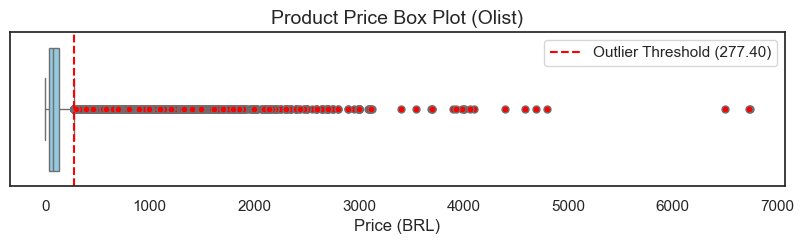

--- PRICE OUTLIER REPORT ---
Upper Limit (IQR): 277.40
Total Outlier Records: 8427 rows
Outlier Percentage: 7.48%

--- TIMELINE ANALYSIS ---
Outliers first appeared on : 2016-10-04 12:06:11
Until                      : 2018-08-28 20:49:17
Time span                  : 693 days


In [172]:
# 2. Calculate IQR to detect Price Outliers
Q1 = sellers_df['price'].quantile(0.25)
Q3 = sellers_df['price'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR

# 3. Identify Outlier Data
outliers_df = sellers_df[sellers_df['price'] > upper_limit].copy()

# 4. Analyze Outlier Timeframe
first_outlier = outliers_df['order_purchase_timestamp'].min()
last_outlier = outliers_df['order_purchase_timestamp'].max()
duration = last_outlier - first_outlier

# 5. Box Plot Visualization
plt.figure(figsize=(10, 2))
sns.boxplot(x=sellers_df['price'], color='skyblue', flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 5})
plt.axvline(upper_limit, color='red', linestyle='--', label=f'Outlier Threshold ({upper_limit:.2f})')
plt.title('Product Price Box Plot (Olist)', fontsize=14)
plt.xlabel('Price (BRL)')
plt.legend()
plt.show()

# 6. Print Report for Reviewers
print(f"--- PRICE OUTLIER REPORT ---")
print(f"Upper Limit (IQR): {upper_limit:.2f}")
print(f"Total Outlier Records: {len(outliers_df)} rows")
print(f"Outlier Percentage: {(len(outliers_df)/len(sellers_df)*100):.2f}%")
print(f"\n--- TIMELINE ANALYSIS ---")
print(f"Outliers first appeared on : {first_outlier}")
print(f"Until                      : {last_outlier}")
print(f"Time span                  : {duration.days} days")


In [173]:
# Calculate the revenue contribution of outliers
revenue_outlier = outliers_df['price'].sum()
total_revenue = sellers_df['price'].sum()

# Display the percentage contribution of outliers to the total revenue
print(f"Outlier Contribution to Total Revenue: {(revenue_outlier/total_revenue*100):.2f}%")

Outlier Contribution to Total Revenue: 35.61%


> **Note on Data Handling:** I have made the strategic decision to **retain the price outliers** in this analysis. While they are statistically infrequent, they account for **35.61% of total revenue**. Excluding them would ignore the most significant financial contributors to the platform and lead to an inaccurate assessment of seller importance and churn impact.


### **Section: Evaluating Seller Operational Efficiency**

One of the most critical factors influencing customer satisfaction—and subsequently, seller retention—is **Processing Latency**. This metric measures the internal efficiency of a seller, specifically the time elapsed from the moment an order is **approved** to the moment it is **handed over to the carrier**.

Delays in this initial stage often lead to a "domino effect" in the delivery chain. By analyzing the distribution of processing times, we can:

* **Identify Operational Bottlenecks:** Differentiate between sellers who process orders instantly and those who struggle with backlog.
* **Detect Data Anomalies:** Spot extreme outliers that might indicate system errors or severe merchant negligence.
* **Determine Realistic Benchmarks:** Use the Median rather than the Mean to set fair performance standards for the seller community.

We calculate the `seller_processing_days` by converting the time difference into total seconds and dividing by **86400** to achieve high-precision daily values. We also implement a data cleaning step to remove negative values that may arise from logistical data entry errors.




---

### **Section: Evaluating Seller Operational Efficiency**

One of the most critical factors influencing customer satisfaction—and subsequently, seller retention—is **Processing Latency**. This metric measures the internal efficiency of a seller, specifically the time elapsed from the moment an order is **approved** to the moment it is **handed over to the carrier**.

Delays in this initial stage often lead to a "domino effect" in the delivery chain. By analyzing the distribution of processing times, we can:

* **Identify Operational Bottlenecks:** Differentiate between sellers who process orders instantly and those who struggle with backlog.
* **Detect Data Anomalies:** Spot extreme outliers that might indicate system errors or severe merchant negligence.
* **Determine Realistic Benchmarks:** Use the Median rather than the Mean to set fair performance standards for the seller community.

We calculate the `seller_processing_days` by converting the time difference into total seconds and dividing by **86400** to achieve high-precision daily values. We also implement a data cleaning step to remove negative values that may arise from logistical data entry errors.



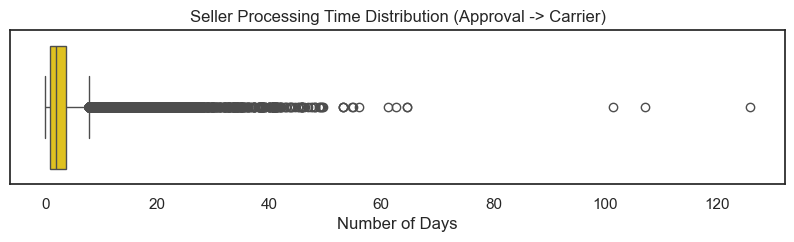

--- SELLER PROCESSING STATISTICS ---
Minimum   : 0.0002 days (Highly efficient)
Maximum   : 125.76 days (Extreme outlier)
Mean      : 2.91 days
Median    : 1.87 days (Typical performance)


In [174]:


# 1. Calculate time difference in days (Using total_seconds for hour/minute precision)
# 86400 is the number of seconds in a day
sellers_df['seller_processing_days'] = (
    sellers_df['order_delivered_carrier_date'] - sellers_df['order_approved_at']
).dt.total_seconds() / 86400

# 2. Filter for valid data (Exclude negative values caused by input errors)
temp_analysis = sellers_df[sellers_df['seller_processing_days'] >= 0].copy()

# 3. Extract key statistics
min_val = temp_analysis['seller_processing_days'].min()
max_val = temp_analysis['seller_processing_days'].max()
mean_val = temp_analysis['seller_processing_days'].mean()
median_val = temp_analysis['seller_processing_days'].median()

# 4. Boxplot Visualization
plt.figure(figsize=(10, 2))
sns.boxplot(x=temp_analysis['seller_processing_days'], color='gold')
plt.title('Seller Processing Time Distribution (Approval -> Carrier)')
plt.xlabel('Number of Days')
plt.show()

print(f"--- SELLER PROCESSING STATISTICS ---")
print(f"Minimum   : {min_val:.4f} days (Highly efficient)")
print(f"Maximum   : {max_val:.2f} days (Extreme outlier)")
print(f"Mean      : {mean_val:.2f} days")
print(f"Median    : {median_val:.2f} days (Typical performance)")

In [175]:
# Calculate IQR for seller_processing_days
Q1_s = sellers_df['seller_processing_days'].quantile(0.25)
Q3_s = sellers_df['seller_processing_days'].quantile(0.75)
IQR_s = Q3_s - Q1_s

# Define the upper bound for normal processing time (Outlier Threshold)
upper_s = Q3_s + 1.5 * IQR_s

print(f"Upper bound for normal processing: {upper_s:.2f} days")

Upper bound for normal processing: 7.78 days




### **Operational Inefficiency (Outlier Analysis)**

After identifying the general distribution of processing times, we need to isolate and examine the **"Extreme Outliers"**. These are instances where the seller's internal processing time (from order approval to carrier pickup) significantly exceeds the normal operational threshold.

The goal of this analysis is to identify which specific product categories are most prone to severe delays. By pinpointing these categories, we can determine whether the delays are inherent to the **product type** (e.g., large furniture requiring special handling) or indicative of **seller-level operational failures**.

* **Thresholding:** We define "extreme delay" using the calculated `upper_s` boundary (derived from the Interquartile Range method).
* **Segmented Aggregation:** We filter the dataset to include only these outliers and group them by their English product category names.
* **Metrics:** We evaluate the **Volume (Count)**, **Average Delay (Mean)**, and **Maximum Delay (Max)** to assess the severity of the bottleneck within each category.

--- TOP 10 PRODUCT CATEGORIES WITH LONGEST SELLER PROCESSING TIME ---


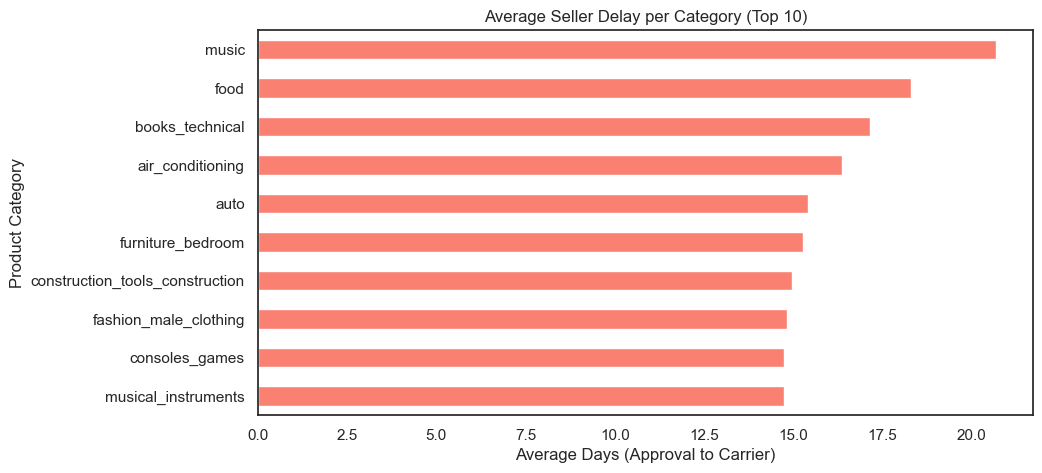

                                 count       mean        max
product_category_name_english                               
music                                2  20.680851  29.950081
food                                 4  18.302801  34.886852
books_technical                      6  17.152710  32.503993
air_conditioning                    37  16.365963  24.953333
auto                               157  15.411123  61.150509
furniture_bedroom                    9  15.284895  34.047512
construction_tools_construction     19  14.964232  49.025440
fashion_male_clothing               19  14.821370  31.814271
consoles_games                      95  14.745141  42.126134
musical_instruments                 36  14.730977  49.594074


In [176]:
# 1. Extract data where processing time exceeds 15 days (defined as the 'extreme delay' threshold)
# We use the calculated 'upper_s' as our specific outlier boundary
late_sellers = sellers_df[sellers_df['seller_processing_days'] > upper_s].copy()

# 2. Group by product category and calculate the average delay statistics
# (Note: This assumes a merge with 'product_category_name_english' has been performed)
top_late_categories = late_sellers.groupby('product_category_name_english')['seller_processing_days'].agg(['count', 'mean', 'max']).sort_values(by='mean', ascending=False)

# 3. Display the top 10 categories with the longest processing times
print("--- TOP 10 PRODUCT CATEGORIES WITH LONGEST SELLER PROCESSING TIME ---")


# 4. Visualization
plt.figure(figsize=(10, 5))
top_late_categories['mean'].head(10).plot(kind='barh', color='salmon')
plt.title('Average Seller Delay per Category (Top 10)')
plt.xlabel('Average Days (Approval to Carrier)')
plt.ylabel('Product Category')
plt.gca().invert_yaxis()  # Display highest values at the top
plt.show()

print(top_late_categories.head(10))



### **Statistical Analysis & Business Interpretations**

* **Statistical Findings:**
The average seller processing time is **2.91 days**. However, the **Median (1.87 days)** more accurately represents the majority's performance, as the data is skewed by extreme outliers reaching up to **125 days**.
* **Outlier Identification:**
It was identified that product categories such as **Music, Food, and Technical Books** exhibit the longest average processing times, consistently exceeding **17 days**.

---

### **Business Interpretation:**

1. **Logistics for Oversized Items:** High-volume or bulky categories, such as **Furniture** or **Air Conditioning**, show naturally longer processing times. This is considered acceptable due to the logistical complexities and specialized handling required for heavy goods.
2. **Operational Inefficiency:** Conversely, long processing times in **small or lightweight product categories** are a significant concern. This indicates potential issues with **stock management** or **unresponsive seller operations**, which are primary drivers for customer dissatisfaction and eventual churn.




### **Strategic Analysis: Pinpointing Market Hotspots & Expansion Gaps**

This phase of the analysis identifies high-growth opportunities for the Olist platform. Rather than looking solely at total volume, we focus on the **"Market Tension"**—the imbalance between Supply (Sellers) and Demand (Orders/Buyers).

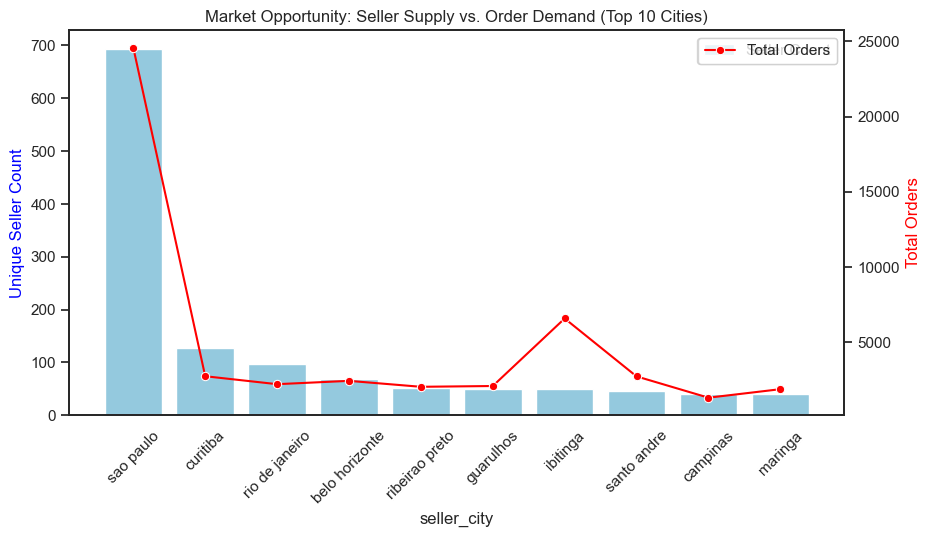

In [177]:
# Preparing data for the chart
# Aggregating Top 10 Cities to analyze the intersection of Seller supply and Order demand
city_stats = sellers_df.groupby('seller_city').agg({
    'seller_id': 'nunique',
    'order_id': 'nunique'
}).sort_values(by='seller_id', ascending=False).head(10)

# Creating a dual-axis visualization (Bar + Line chart)
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bars for the Number of Sellers
sns.barplot(x=city_stats.index, y=city_stats['seller_id'], color='skyblue', label='Seller Count', ax=ax1)
ax1.set_ylabel('Unique Seller Count', color='blue')
ax1.tick_params(axis='x', rotation=45)

# Line for the Number of Orders (Secondary Axis)
ax2 = ax1.twinx()
sns.lineplot(x=city_stats.index, y=city_stats['order_id'], color='red', marker='o', label='Total Orders', ax=ax2)
ax2.set_ylabel('Total Orders', color='red')

plt.title('Market Opportunity: Seller Supply vs. Order Demand (Top 10 Cities)')
plt.show()



#### **1. Market Opportunity: Supply vs. Demand (Top 10 Cities)**

This visualization compares the count of unique sellers against total order volume to assess market maturity and saturation levels across major cities.

* **São Paulo Dominance:** São Paulo shows a high density of sellers (~700) and a massive order volume (~25,000). This indicates a highly mature market but also implies fierce competition for local merchants.
* **The Ibitinga Anomaly:** The city of **Ibitinga** presents a fascinating outlier. Despite having relatively few sellers (~50), its order volume is significantly higher than cities with similar seller counts (like Guarulhos or Santo André). This suggests high merchant efficiency or a specialized product cluster that attracts nationwide demand.

#### **2. Local Merchant Supply vs. Expansion Priority Index**

This analysis shifts the focus to **"Expansion Gaps"**—cities with high buyer activity but almost no local merchant presence.

* **Extreme Supply Scarcity:** Cities such as **Guariba, Ilicinea,** and **Campo Limpo Paulista** currently operate with only 1 to 2 active local sellers.
* **Expansion Priority Index (Buyer-to-Seller Ratio):**
* **Guariba** holds the highest priority with a ratio of **1132.0**. This means every single local seller in Guariba "represents" a potential pool of over 1,100 unique buyers.
* **Ilicinea (718.0)** and **Campo Limpo Paulista (563.5)** also exhibit critical imbalances, suggesting these markets are heavily under-served by local supply.



---

### **Recommendations**

Based on the data insights, Olist’s expansion strategy should follow three primary tracks:

1. **Targeted Merchant Acquisition:** The Sales and Partnerships team should launch focused recruitment campaigns in **Guariba, Ilicinea,** and **Campo Limpo Paulista**. Onboarding new sellers in these specific zones will drastically reduce the costs associated with long-distance, cross-city shipping.
2. **Logistics Optimization in Ibitinga:** Given Ibitinga's high order output relative to its seller count, this city is an ideal candidate for a dedicated **Collection Point** or logistics hub to streamline high-volume fulfillment.
3. **Local-to-Local Strategy:** By filling the supply gap in regions with high buyer-to-seller ratios, Olist can offer faster delivery estimates (Same-day or Next-day delivery). Localizing the supply chain improves both profit margins and customer retention.



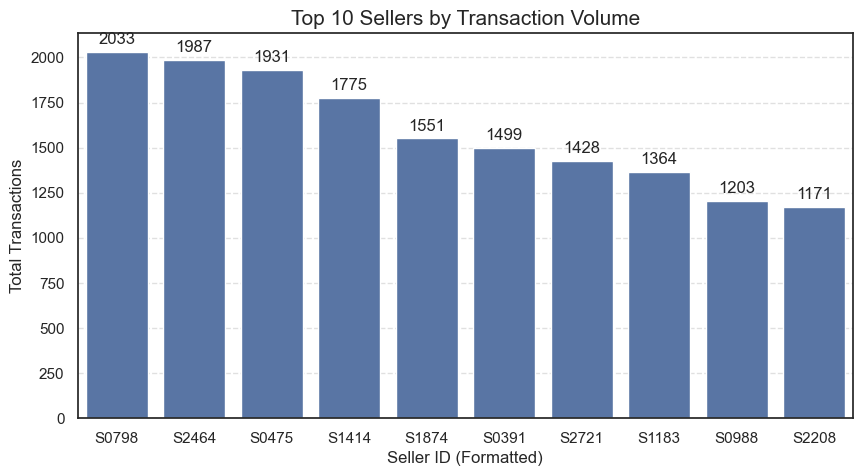

Seniority Details for Top 10 Sellers:
seller_id  total_transactions  tenure_days
    S0798                2033          555
    S2464                1987          594
    S0475                1931          507
    S1414                1775          569
    S1874                1551          568
    S0391                1499          395
    S2721                1428          412
    S1183                1364          569
    S0988                1203          371
    S2208                1171          572


In [178]:
# 1. Calculate Transactions and Tenure (Sales Duration) for the Top 10
top_10_stats = sellers_df.groupby('seller_id').agg(
    total_transactions=('seller_id', 'count'),
    first_transaction=('shipping_limit_date', 'min'),
    last_transaction=('shipping_limit_date', 'max')
).reset_index()

# Calculate tenure in days
top_10_stats['tenure_days'] = (top_10_stats['last_transaction'] - top_10_stats['first_transaction']).dt.days

# Get the top 10 sellers based on transaction volume
top_10_final = top_10_stats.sort_values(by='total_transactions', ascending=False).head(10)

# 2. Visualization
plt.figure(figsize=(10, 5))

# Create Bar Chart
ax = sns.barplot(
    x='seller_id', 
    y='total_transactions', 
    data=top_10_final, 
    order=top_10_final['seller_id'] # Sorted from highest to lowest
)

# Add numerical labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.title('Top 10 Sellers by Transaction Volume', fontsize=15)
plt.xlabel('Seller ID (Formatted)', fontsize=12)
plt.ylabel('Total Transactions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 3. Display the seniority details for the Top 10
print("Seniority Details for Top 10 Sellers:")
print(top_10_final[['seller_id', 'total_transactions', 'tenure_days']].to_string(index=False))


### **Top Seller Retention and Performance**

* **Consistency & Retention:**
The majority of the Top 10 sellers have been active for **1.5 to 2 years (400–500+ days)**. This longevity indicates that the Olist platform provides a strong **Return on Investment (ROI)** for large-scale merchants, fostering long-term retention and sustainable business growth.
* **Operational Focus:**
**Seller S2208** currently holds the 10th position with **1,171 transactions** despite a long tenure of **572 days**. When compared to **S0988**—who is significantly newer yet has secured more transactions—it suggests that S2208 may be experiencing a **performance plateau** or is operating within a slower-growth niche market.

---

### **Conclusion:**

"The data identifies **S0798** as the primary contributor to transaction volume, while **S2464** stands out as our most loyal partner with nearly **600 days** of active tenure. Furthermore, we observe significant potential in emerging merchants like **S0988**, who has achieved remarkable hyper-growth within just one year."

In [179]:

# Calculate delivery time in days
sellers_df['delivery_time'] = (
    sellers_df['order_delivered_customer_date'] - sellers_df['order_purchase_timestamp']
).dt.total_seconds() / 86400

# 2. Calculate Delivery Performance for all sellers (Mean & Median)
delivery_stats = sellers_df.groupby('seller_id')['delivery_time'].agg(['mean', 'median']).reset_index()
delivery_stats.columns = ['seller_id', 'delivery_mean', 'delivery_median']

# 3. Merge results into the existing top_10_final table
top_10_final = pd.merge(top_10_final, delivery_stats, on='seller_id', how='left')

# 4. Display the results
print("Top 10 Seller Performance (Transactions + Delivery Time):")
print(top_10_final[['seller_id', 'total_transactions', 'tenure_days', 'delivery_mean', 'delivery_median']].to_string(index=False))

Top 10 Seller Performance (Transactions + Delivery Time):
seller_id  total_transactions  tenure_days  delivery_mean  delivery_median
    S0798                2033          555       9.539486         7.760260
    S2464                1987          594      14.416471        11.973391
    S0475                1931          507      15.571831        13.983802
    S1414                1775          569      11.539753         9.269039
    S1874                1551          568      11.169687         8.284225
    S0391                1499          395      10.740379         8.340787
    S2721                1428          412      12.051349        10.101013
    S1183                1364          569      22.392546        19.863634
    S0988                1203          371      13.315562        10.859919
    S2208                1171          572      11.170944         9.392940




This analysis evaluates the correlation between transaction volume, merchant seniority (tenure), and logistical efficiency among the top 10 sellers on the Olist platform.

#### **Key Insights & Strategic Observations**

**1. Scalability vs. Efficiency (The Gold Standard)** **Seller S0798** stands out as the top performer, successfully balancing high transaction volume (**2,033 orders**) with the fastest delivery speed (**Median: 7.0 days**). This indicates a highly optimized supply chain and robust inventory management. From a business perspective, this seller represents the "Ideal Partner" profile with the lowest churn risk.

**2. The Veteran Stability Factor** **Seller S2464** is the most senior merchant with **594 days** of activity. Their delivery performance is remarkably stable (Median: 11 days).

* **Insight:** Long-term tenure on the platform correlates with predictable logistics. These "Veteran" sellers are the backbone of platform stability and are less likely to churn compared to newer, high-growth "sprinters."

**4. Logistical Distribution (Mean vs. Median Gap)** Across all top sellers, the **Mean** delivery time is consistently higher than the **Median**.

* **Insight:** This confirms a **Positive Skew** in the data. While the majority of orders are delivered promptly, a small percentage of "extreme outliers" (delayed shipments) inflates the average. Strategic focus should be on reducing these outliers to improve overall customer satisfaction.

---

The data suggests that **transaction volume is not a barrier to delivery speed**, as evidenced by S0798. However, the platform should intervene with sellers like S1183, who exhibit high volume but poor logistical health, to prevent impending churn and negative brand impact.

---
### **Section: Market Hotspot Analysis – Identifying Strategic Expansion Gaps**

Following data cleansing and geospatial integration, we move into a strategic phase to identify growth opportunities. This analysis utilizes the concept of **"Market Tension"**—identifying cities where buyer demand is exceptionally high but is not supported by a sufficient number of local merchants.

/var/folders/dc/s4_2lkhj1w71d400jbv_shvm0000gn/T/ipykernel_33135/2462132487.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ratio', y='seller_city', data=top_cities, palette='crest', ax=ax_right)


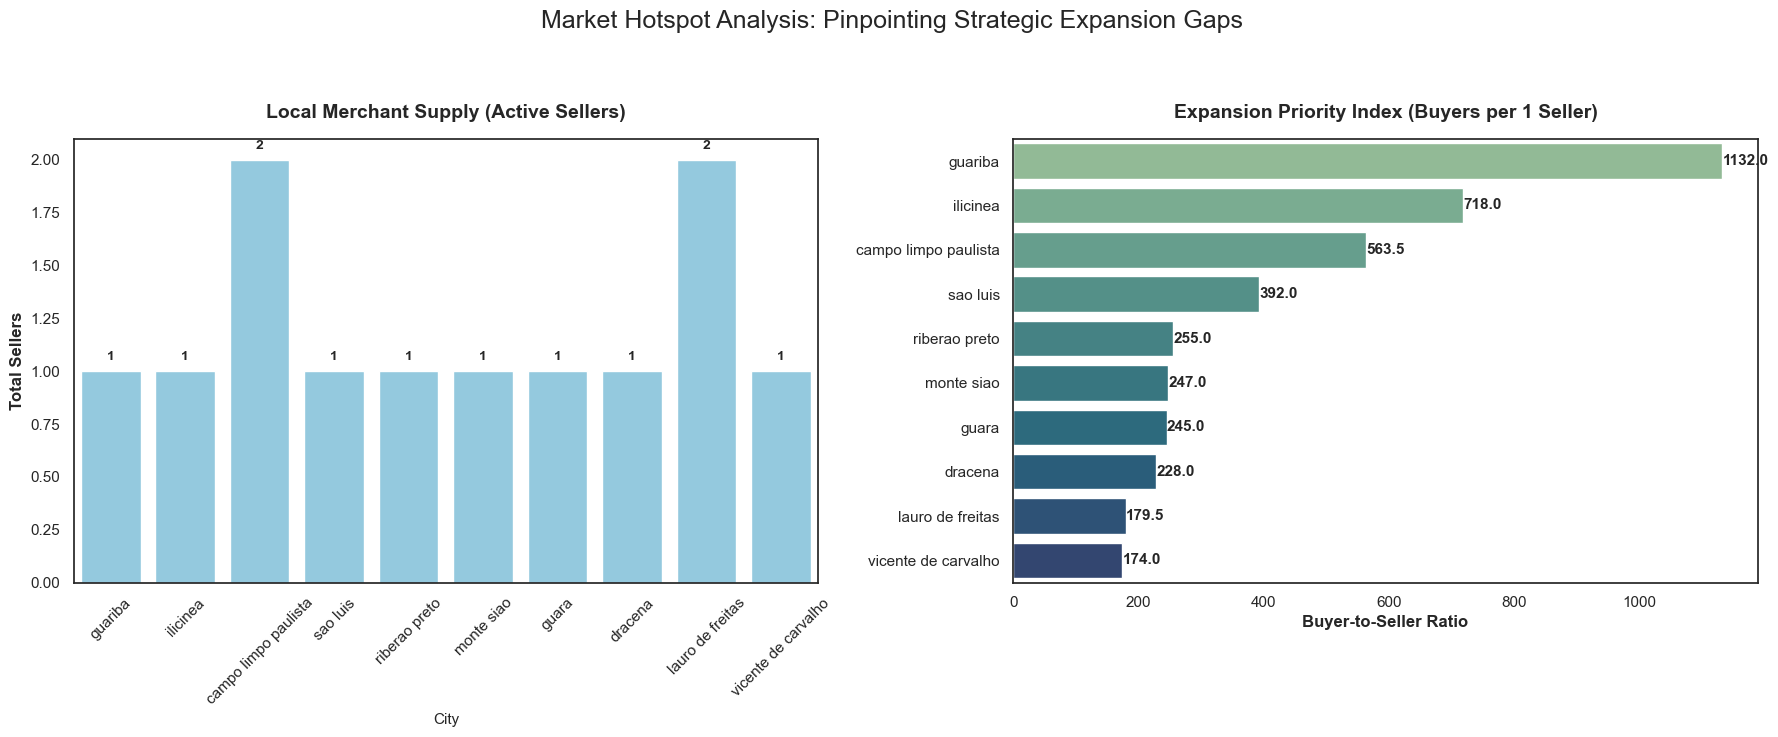

In [180]:


# 1. Aggregate Data per City
market_gap_city = sellers_df.groupby('seller_city').agg(
    total_sellers=('seller_id', 'nunique'),
    total_buyers=('customer_id', 'nunique')
).reset_index()

# 2. Calculate the Opportunity Ratio (Demand per 1 Supply)
market_gap_city['ratio'] = market_gap_city['total_buyers'] / market_gap_city['total_sellers']

# 3. Filter Top 10 High-Ratio Cities (Focusing on low supply, high demand)
top_cities = market_gap_city.sort_values('ratio', ascending=False).head(10)

# 4. Create Side-by-Side Subplots
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18, 7))
sns.set_theme(style="white")

# --- LEFT CHART: Supply Volume (Total Sellers Only) ---
sns.barplot(x='seller_city', y='total_sellers', data=top_cities, color='skyblue', ax=ax_left)
ax_left.set_title('Local Merchant Supply (Active Sellers)', fontsize=14, fontweight='bold', pad=15)
ax_left.set_ylabel('Total Sellers', fontsize=12, fontweight='bold')
ax_left.set_xlabel('City', fontsize=11)
ax_left.tick_params(axis='x', rotation=45)

# Add values on top of bars
for p in ax_left.patches:
    ax_left.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=10, fontweight='bold')

# --- RIGHT CHART: Expansion Priority (The Ratio) ---
sns.barplot(x='ratio', y='seller_city', data=top_cities, palette='crest', ax=ax_right)
ax_right.set_title('Expansion Priority Index (Buyers per 1 Seller)', fontsize=14, fontweight='bold', pad=15)
ax_right.set_xlabel('Buyer-to-Seller Ratio', fontsize=12, fontweight='bold')
ax_right.set_ylabel('') # Clean up Y-axis for horizontal chart

# Add actual ratio numbers to the priority bars
for i, v in enumerate(top_cities['ratio']):
    ax_right.text(v + 0.5, i, f'{v:.1f}', va='center', fontweight='bold', fontsize=11)

plt.suptitle('Market Hotspot Analysis: Pinpointing Strategic Expansion Gaps', fontsize=18, y=1.05)
plt.tight_layout()
plt.show()




#### **Visualization Methodology**

This analysis employs a side-by-side comparison to provide a comprehensive view of market dynamics:

1. **Left Chart (Local Merchant Supply):** Displays the absolute number of active sellers in selected cities. We observe that these high-potential cities currently have very few local merchants (often as low as 1 or 2).
2. **Right Chart (Expansion Priority Index):** Displays the ratio of unique buyers per single seller. A higher ratio indicates a greater market imbalance and a higher dependency on "out-of-state" shipments.

#### **Key Interpretations & Business Insights**

Based on the results, we can derive several crucial points for Olist’s business strategy:

* **The Guariba Opportunity:** The city of **Guariba** ranks first with a priority index of **1132.0**. This means that, theoretically, one local seller is serving over 1,100 unique buyers. This is a strong indicator of either a local monopoly or a heavy reliance on expensive long-distance logistics.
* **Critical Supply Gaps:** Cities such as **Ilicinea** and **Campo Limpo Paulista** also show extreme ratios (exceeding 500 buyers per seller) with a negligible local seller presence.
* **Strategic Recommendations:**
* **Recruitment Priority:** The Olist Partnership team should prioritize the acquisition of new merchants residing in **Guariba, Ilicinea,** and **Campo Limpo Paulista**.
* **Logistical Optimization:** By increasing the seller density in these hubs, Olist can implement "local-to-local" shipping strategies. This reduces transit times and shipping costs compared to cross-country fulfillment.



---

### **Conclusion**

The data demonstrates that Olist’s growth across Brazil is unevenly distributed. By focusing on cities with a **High Buyer-to-Seller Ratio**, the platform can achieve an immediate impact: lowering operational shipping costs and increasing customer satisfaction through significantly faster delivery speeds.


# Comprehensive Analytical Conclusion & Strategic Roadmap

### 1. Micro-Analysis: Key Diagnostics (Bedah Masalah)

Before recommending solutions, we must isolate the specific diagnoses derived from the data audit.

#### A. The "First Mile" Efficiency Gap
*   **Finding:** While the median seller processing time is efficient (**1.87 days**), the mean is skewed to **2.91 days** by extreme outliers.
*   **The Problem:** Specific categories are systemic bottlenecks. **Music, Food, and Technical Books** consistently average over **17 days** just to hand items to carriers.
*   **Impact:** This "First Mile" delay is the primary controllable factor in late deliveries. A 17-day delay at the start guarantees a dissatisfied customer, regardless of how fast the courier drives.

#### B. The "Supply Desert" Phenomenon
*   **Finding:** Our geospatial analysis identified a critical imbalance. The city of **Guariba** has a Buyer-to-Seller ratio of **1,132 : 1**, followed closely by **Ilicinea (718 : 1)**.
*   **The Problem:** Olist is currently servicing these high-demand areas using "Imported Logistics" (shipping from far away), which kills profit margins due to high freight costs.
*   **Impact:** These cities represent "Leftover Money"—demand that exists but is being served inefficiently.

#### C. The "Revenue Quality" Insight
*   **Finding:** We detected price outliers (high-ticket items). While statistically rare, these transactions contribute **35.61% of Total Revenue** .
*   **Impact:** Treating these sellers the same as low-value sellers is a strategic error. Losing one "Premium Seller" hurts the bottom line significantly more than losing ten average sellers.

---

### 2. Integrated Synthesis: Connecting the Dots
*How do these findings relate to each other?*

**1. Scalability vs. Speed (The S0798 vs. S1183 Case)**
Data shows that high volume does *not* necessitate slow speed.
*   **Seller S0798** handles 2,033 orders with a 7-day delivery median.
*   **Seller S1183** handles 1,364 orders but lags with a ~20-day median.
*   **Conclusion:** Slowness is an operational choice, not a scaling consequence. Seller S1183 is a high-risk entity (High Volume + Poor Service = Brand Damage).

**2. The Churn Equation**
Our analysis defines "Churn Risk" not just by inactivity, but by **Operational Decay**. Sellers with an average processing time **>7 days** are technically active but operationally failing. These sellers are the precursors to churn.

---

### 3. Strategic Business Recommendations

Based on the synthesis above, we propose a 3-point strategy for Olist stakeholders:

#### Strategy 1: The "Local-to-Local" Expansion (Partnership Team)
*   **Action:** Launch aggressive merchant acquisition campaigns in **Guariba, Ilicinea, and Campo Limpo Paulista**.
*   **Rationale:** By placing inventory where the demand is (1,132 buyers in Guariba), we unlock "Same-Day Delivery" potential and slash logistics costs.
*   **KPI:** Reduce Buyer-to-Seller ratio in these cities to under 100:1 within Q4.

#### Strategy 2: Proactive Churn Defense (Account Management Team)
*   **Action:** Implement an automated "Health Scorecard."
*   **Mechanism:** If a seller's `avg_processing_days` exceeds **3 days** (Regional Median + Buffer), trigger an intervention.
*   **Specific Target:** Immediately audit **Seller S1183**. Despite high revenue, their 20-day delivery timeline is a ticking time bomb for customer churn.
*   **Goal:** Shift from "Retaining Inactive Sellers" to "Fixing Slow Sellers."

#### Strategy 3: Specialized Logistics Tier (Operations Team)
*   **Action:** Differentiate logistics support based on category and value.
    1.  **High Value:** The top 35% revenue drivers (Outliers) get priority support.
    2.  **High Complexity:** Establish a specialized "Oversized Hub" in **Ibitinga** to handle the slow-moving categories like Furniture and Air Conditioning.
*   **Rationale:** You cannot fix a 17-day processing delay in "Air Conditioning" with standard courier services; it requires specialized warehousing support.

### 3. Final Verdict
Data integrity was a major challenge in this analysis. By implementing **Seller-Specific Median Imputation**, we recovered accurate timelines for logistics analysis. Moving forward, Olist must address the spatial imbalance between Buyers and Sellers to transition from a "Marketplace" to a "Strategic Logistics Partner."
